## Read Identities calculated for Simulated DNA R9, R10 and RNA002 data

The simulated data was created from a truth dataset, which is included in this directory.

We simulate the signal from the truth sequence, which has the actual location of the read from the reference fasta, which is for Hg38 chr 20.

We then base call and align the base-called sequence and look for the read identity (Gap-compressed identity) .

See http://lh3.github.io/2018/11/25/on-the-definition-of-sequence-identity

Relies on an installed and running version of `dorado_basecall_server`, which can be installed with MinKNOW, or standalone from https://community.nanoporetech.com/downloads.

The version used for my Thesis was v7.3.9.


In [48]:
import collections
import csv
import random
import re
import time as t
from contextlib import contextmanager, redirect_stdout
from io import StringIO
from itertools import islice
from pathlib import Path
from random import sample

import mappy as mp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import seaborn as sns
from mappy import fastx_read
from matplotlib import font_manager, rcParams
from natsort import natsorted
from pybasecall_client_lib import helper_functions
from pybasecall_client_lib.pyclient import PyBasecallClient
from pyfastx import Fasta
from python_scripts.make_squiggle import get_sequence, progress_bar_setup

In [49]:
plt.style.use("../dotfiles-rm/thesis/thesis.mplstyle")
font_dir = "../dotfiles-rm/"
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
sns.set_palette("colorblind")
rcParams["font.family"] = "Roboto"
random.seed(1)

In [50]:
TEST_FASTA = Path("raw_data/r10_identity_seqs.fasta")
R9_OUTDIR = Path("raw_data/r9_squiggle")
R10_SQUIGGLE_OUTDIR = Path("raw_data/r10_squiggle")
RNAR9_SQUIGGLE_OUTDIR = Path("raw_data/rna9_squiggle")
RNAR9_KMERS_MODEL = Path("kmer_models/5mer_levels_v1.txt")

BIN_PATH = "/usr/bin/"
RANGE = 1
DIGITISATION = 2048
R10_KMERS_MODEL = Path("kmer_models/R10_model.tsv")
SAMPLES = (9, 10)
GUPPY_ADDRESS = "ipc:///tmp/.guppy/5555"

### Create the test data
Always the same as the random seed is fixed

In [51]:
read_length_inc = 50
reads = []
fa = fastx_read(
    "raw_data/hg38_no_alts.part_NC_000020.11 Homo sapiens chromosome 20, GRCh38.p14 Primary Assembly.fa.gz"
)
name, seq, _ = next(fa)

read_start = int(len(seq) / 2)
for i in range(1, 51):
    while True:
        read_length = read_length_inc * i
        read_start = random.randint(0, (len(seq) - 50 * read_length_inc))
        subseq = seq[read_start : read_start + read_length].upper()
        if "N" not in subseq:
            reads.append(
                f">test_read_{i}_{read_start}_{read_start+read_length}\n{subseq}"
            )
            break

# Write out the data
with open(TEST_FASTA, "w") as fh:
    fh.write("\n".join(reads))

### Helper functions for basecalling

In [52]:
def pack(read: dict[str, str | npt.NDArray[np.int16]]):
    """Pack an ont_fast5_api.Fast5Read for calling
    passed dict has two fields, read_id and raw_Data
    read_id: str, raw_data: npt.NDArray[np.int16]
    """
    read_id = read["read_id"]
    raw_data = read["raw_data"]
    sample_rate = read.pop("sample_rate", 4000.0)
    scaling = RANGE / DIGITISATION
    offset = 0.0
    return helper_functions.package_read(
        read_id,
        raw_data,
        offset,
        scaling,
        sampling_rate=sample_rate,
        start_time=int(100),
    )

In [53]:
@contextmanager
def start_guppy_server_and_client(bin_path, config, port, server_args):
    server_args.extend(
        [
            "--config",
            config,
            "--port",
            port,
            "--log_path",
            str((Path(".") / "dorado_logs")),
        ]
    )
    # This function has it's own prints that may want to be suppressed
    with redirect_stdout(StringIO()) as fh:
        server, port = helper_functions.run_server(server_args, bin_path=bin_path)

    if port == "ERROR":
        raise RuntimeError("Server couldn't be started")

    if port.startswith("ipc"):
        address = f"{port}"
    else:
        address = f"localhost:{port}"
    client = PyBasecallClient(address=address, config=config)

    try:
        with client:
            yield client
    finally:
        server.terminate()

### Helper function for Gap Compressed identity

In [54]:
def gap_compressed_identity(al) -> float:
    nm_match = al.NM
    print(f"nm {nm_match}")
    if nm_match:
        # Total mismatches
        n = nm_match
        line = al.cigar_str
        # Initialize variables
        m = 0  # Sum of matches (M operations)
        g = 0  # Sum of gaps (I and D operations)
        o = 0  # Number of gap opens

        # Find all M operations and sum them
        m_operations = re.findall(r"(\d+)M", line)
        m = sum(int(match) for match in m_operations)

        # Find all I and D operations and process them
        gap_operations = re.findall(r"(\d+)[ID]", line)
        for match in gap_operations:
            g += int(match)
            o += 1

        # Calculate identity
        identity = (1 - (n - g + o) / (m + o)) if (m + o) != 0 else 0

        # Print the result
        print(identity)
        return identity
    elif nm_match == 0:
        return 1.0

## R9 data
### Create R9 Squiggle

In [55]:
# make directory if it doesn't already exist
R9_OUTDIR.mkdir(exist_ok=True)
job_progress, overall_progress, progress_table, task_lookup = progress_bar_setup(1)
barcode = None
get_sequence(
    TEST_FASTA.resolve(),
    R9_OUTDIR,
    job_progress,
    task_lookup,
    0,
    barcode,
    None,
)

[05/22/24 16:51:09] INFO     Generating squiggle for test_read_1_9017031_9017081               ]8;id=800798;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=459158;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=362493;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=242081;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_1_9017031_9017081.squiggle.npy                         
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_2_38198625_38198725             ]8;id=998500;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=303858;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=960778;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=583484;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_2_38198625_38198725.squiggle.npy                       
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_3_56870315_56870465             ]8;id=659924;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=758790;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=348856;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=939078;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_3_56870315_56870465.squiggle.npy                       
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_4_53839096_53839296             ]8;id=442611;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=532380;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=318104;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=297962;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_4_53839096_53839296.squiggle.npy                       
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_5_51256047_51256297             ]8;id=986619;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=529828;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=503554;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=254531;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_5_51256047_51256297.squiggle.npy                       
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_6_4235027_4235327               ]8;id=697034;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=181411;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=813524;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=707249;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_6_4235027_4235327.squiggle.npy                         
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_7_17117392_17117742             ]8;id=696000;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=533123;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=880753;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=412357;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_7_17117392_17117742.squiggle.npy                       
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_8_7913390_7913790               ]8;id=492117;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=45599;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=621998;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=606261;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_8_7913390_7913790.squiggle.npy                         
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_9_33248085_33248535             ]8;id=526635;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=237961;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=964780;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=902079;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_9_33248085_33248535.squiggle.npy                       
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_10_51067325_51067825            ]8;id=360527;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=998734;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=953947;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=282359;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_10_51067325_51067825.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_11_30164834_30165384            ]8;id=5986;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=402327;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=984045;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=776474;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_11_30164834_30165384.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_12_31691841_31692441            ]8;id=815160;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=588626;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=504471;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=912271;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_12_31691841_31692441.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_13_43727664_43728314            ]8;id=986724;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=529237;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=434555;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=362889;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_13_43727664_43728314.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_14_25475546_25476246            ]8;id=824646;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=642202;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=843652;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=240758;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_14_25475546_25476246.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_15_52930328_52931078            ]8;id=189565;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=902833;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=892625;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=856096;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_15_52930328_52931078.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_16_14089828_14090628            ]8;id=989405;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=705810;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=475003;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=15267;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_16_14089828_14090628.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_17_6298810_6299660              ]8;id=281691;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=114807;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=304385;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=72892;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_17_6298810_6299660.squiggle.npy                        
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_18_32739506_32740406            ]8;id=998199;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=176312;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=308798;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=476789;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_18_32739506_32740406.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_19_1902366_1903316              ]8;id=119737;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=24782;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=834879;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=197173;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_19_1902366_1903316.squiggle.npy                        
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_20_59949491_59950491            ]8;id=765620;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=534895;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=21829;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=236321;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_20_59949491_59950491.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_21_56087246_56088296            ]8;id=753753;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=168010;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=447390;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=571161;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_21_56087246_56088296.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_22_26159626_26160726            ]8;id=728813;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=541693;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=32191;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=414080;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_22_26159626_26160726.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_23_29042506_29043656            ]8;id=691875;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=661596;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=131788;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=222436;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_23_29042506_29043656.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_24_40764473_40765673            ]8;id=900217;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=80159;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=779974;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=165892;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_24_40764473_40765673.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_25_51155750_51157000            ]8;id=8892;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=587954;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=859217;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=228160;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_25_51155750_51157000.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_26_51483077_51484377            ]8;id=868129;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=909934;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=533592;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=39241;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_26_51483077_51484377.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_27_141334_142684                ]8;id=215756;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=601235;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=203548;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=516267;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_27_141334_142684.squiggle.npy                          
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_28_46696553_46697953            ]8;id=310454;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=528594;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=913961;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=421868;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_28_46696553_46697953.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_29_29889428_29890878            ]8;id=210609;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=899192;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=141707;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=355567;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_29_29889428_29890878.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_30_17873141_17874641            ]8;id=101088;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=878393;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=958864;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=925256;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_30_17873141_17874641.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_31_48421731_48423281            ]8;id=805255;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=558388;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=88793;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=139478;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_31_48421731_48423281.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_32_53809656_53811256            ]8;id=223313;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=281028;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=881991;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=267692;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_32_53809656_53811256.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_33_15351972_15353622            ]8;id=305361;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=246614;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=749845;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=930364;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_33_15351972_15353622.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_34_39671635_39673335            ]8;id=807668;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=109340;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=398700;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=908243;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_34_39671635_39673335.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_35_63436042_63437792            ]8;id=357456;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=120260;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=396403;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=80375;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_35_63436042_63437792.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_36_6860348_6862148              ]8;id=85714;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=998502;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=591865;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=560248;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_36_6860348_6862148.squiggle.npy                        
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_37_60493772_60495622            ]8;id=290647;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=112963;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=12983;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=643486;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_37_60493772_60495622.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_38_21302342_21304242            ]8;id=120693;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=866249;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=251273;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=823669;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_38_21302342_21304242.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_39_2052859_2054809              ]8;id=472811;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=175514;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=886066;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=107829;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_39_2052859_2054809.squiggle.npy                        
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_40_1498011_1500011              ]8;id=569298;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=953389;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=746178;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=500181;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_40_1498011_1500011.squiggle.npy                        
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_41_1707642_1709692              ]8;id=332835;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=41544;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=309906;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=761773;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_41_1707642_1709692.squiggle.npy                        
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_42_43590303_43592403            ]8;id=328498;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=417915;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=630662;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=478001;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_42_43590303_43592403.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_43_36333576_36335726            ]8;id=647817;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=815707;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=491698;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=693983;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_43_36333576_36335726.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_44_617732_619932                ]8;id=217932;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=322249;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=859808;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=294426;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_44_617732_619932.squiggle.npy                          
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_45_63025233_63027483            ]8;id=683682;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=602256;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=409446;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=321686;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_45_63025233_63027483.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_46_59138603_59140903            ]8;id=831239;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=888285;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=257790;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=350573;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_46_59138603_59140903.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_47_25582183_25584533            ]8;id=846796;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=624912;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=847525;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=255600;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_47_25582183_25584533.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_48_46069151_46071551            ]8;id=909698;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=74361;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=10398;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=304948;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_48_46069151_46071551.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_49_14535739_14538189            ]8;id=491608;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=904553;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=815525;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=833600;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_49_14535739_14538189.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Generating squiggle for test_read_50_28327763_28330263            ]8;id=697562;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=181657;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#120\120]8;;\

                    WARNING  File with name                                                    ]8;id=861457;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=907590;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#145\145]8;;\
                             raw_data/r9_squiggle/test_read_50_28327763_28330263.squiggle.npy                      
                             already exists. Skipping...                                                           

                    INFO     Creating distributions file.                                      ]8;id=539343;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py\make_squiggle.py]8;;\:]8;id=875235;file:///home/adoni5/Projects/Chapter_1_Data/read_identities/python_scripts/make_squiggle.py#147\147]8;;\

In [57]:
r9_identities = []
with start_guppy_server_and_client(
    BIN_PATH,
    "dna_r9.4.1_450bps_hac.cfg",
    GUPPY_ADDRESS,
    ["--device", "cuda:all"],
) as client:
    fa = Fasta(str(TEST_FASTA.resolve()))
    res = []
    reads_sent, reads_recv = 0, 0
    for signal_array in natsorted(R9_OUTDIR.rglob("*.npy")):
        # remove any non ACGT and replace with A
        read_id = signal_array.stem.partition(".")[0]
        signal = np.load(signal_array)
        read = {"read_id": read_id, "raw_data": signal}
        success_pass = client.pass_read(read, pack)
        reads_sent += 1
        t.sleep(0.1)
    t.sleep(20)
    ress = []
    while reads_recv < reads_sent:
        res = client.get_completed_reads()
        if not res:
            print(reads_recv, reads_sent)
            t.sleep(3)
            continue
        for res_batch in res:
            for r in res_batch:
                ress.append(r)
                reads_recv += 1

for r in sorted(ress, key=lambda x: len(x["datasets"].get("sequence", ""))):
    read_id = r["metadata"]["read_id"]
    reference_fasta = fa[read_id]
    aligner = mp.Aligner(seq=str(reference_fasta))
    read_number = r["metadata"]["read_id"].rsplit("_", 3)[-3]
    sequence = r["datasets"].get("sequence", "")
    query_len = len(sequence)
    als = aligner.map(sequence)
    for al in als:
        r9_identities.append((len(reference_fasta), gap_compressed_identity(al)))

nm 0
nm 5
0.9726027397260274
nm 0
nm 0
nm 3
0.9897610921501706
nm 2
0.9970845481049563
nm 2
0.9949494949494949
nm 2
0.9954954954954955
nm 8
0.9878542510121457
nm 4
0.9925650557620818
nm 5
0.9915966386554622
nm 15
0.9768518518518519
nm 3
0.9956709956709957
nm 6
0.9946164199192463
nm 7
0.9924337957124842
nm 6
0.9928825622775801
nm 11
0.9888017917133258
nm 2
0.9978835978835979
nm 5
0.9949647532729103
nm 12
0.9894128970163619
nm 13
0.9890510948905109
nm 8
0.994750656167979
nm 13
0.9898477157360406
nm 17
0.9887459807073955
nm 15
0.9892141756548536
nm 16
0.9910714285714286
nm 14
0.9921259842519685
nm 2
0.9986159169550173
nm 10
0.9933199732798931
nm 12
0.9922279792746114
nm 12
0.9949653870358716
nm 4
0.9975669099756691
nm 28
0.9934367541766109
nm 21
0.9896848137535816
nm 26
0.9888205701509223
nm 13
0.9951113525258012
nm 9
0.9952556668423828
nm 15
0.9938398357289527
nm 10
0.9949974987493747
nm 19
0.9912280701754386
nm 32
0.9861641221374046
nm 14
0.9939450395901258
nm 18
0.992269213278763
nm 22

## R10

### Generate the R10 signal

In [58]:
def sliding_window(iterable, n):
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


def signalify(
    kmers: dict[str, dict[str, float]], sequence: str, noise: bool = True
) -> npt.NDArray[np.int16]:
    """convert a given sequence to signal using R10 models,
    returning np array containing 10 samples per base"""
    a = []
    # Always upper case signal
    for kmer in sliding_window(sequence.upper(), 9):
        value = kmers["".join(kmer)]
        # value = (value * 2048) / 300 - 57
        for _ in range(sample(SAMPLES, 1)[0]):
            # Multiplied by digitisation and divided by the range
            a.append((value))
    if noise:
        # Add laplace noise
        a = expandy(np.array(a), 1 / np.sqrt(2))
    return a.astype(np.int16)


def read_kmers() -> dict[str, float]:
    kmers = {}
    with open(R10_KMERS_MODEL, newline="") as csvfile:
        reader = csv.DictReader(csvfile, delimiter="\t", fieldnames=["Kmer", "Value"])
        kmers = {row["Kmer"]: float(row["Value"]) for row in reader}
        return kmers


def expandy(arr, n):
    """
    :param arr:
    :param n:
    :return:
    """
    return np.random.laplace(arr, n)

In [59]:
kmers = read_kmers()
fa = Fasta(str(TEST_FASTA.resolve()))
R10_SQUIGGLE_OUTDIR.mkdir(exist_ok=True)
for seq in fa:
    name, seq = seq.name, seq.seq
    signal = signalify(kmers, seq)
    with open(R10_SQUIGGLE_OUTDIR / f"{name}.npy", "wb") as fh:
        np.save(fh, signal, allow_pickle=False)

### Basecall R10 data

In [60]:
r10_identities = []
with start_guppy_server_and_client(
    BIN_PATH,
    "dna_r10.4.1_e8.2_400bps_hac.cfg",
    GUPPY_ADDRESS,
    ["--device", "cuda:all"],
) as client:
    fa = Fasta(str(TEST_FASTA.resolve()))
    reads_sent, reads_recv = 0, 0

    for signal_array in natsorted(R10_SQUIGGLE_OUTDIR.rglob("*.npy")):
        # remove any non ACGT and replace with A
        print(signal_array)
        read_id = signal_array.stem.partition(".")[0]
        signal = np.load(signal_array)
        read = {"read_id": read_id, "raw_data": signal}
        success_pass = client.pass_read(read, pack)
        reads_sent += 1
        t.sleep(0.1)

    t.sleep(20)
    ress = []
    while reads_recv < reads_sent:
        res = client.get_completed_reads()
        if not res:
            print(reads_recv, reads_sent)
            t.sleep(3)
            continue
        for res_batch in res:
            for r in res_batch:
                ress.append(r)
                reads_recv += 1
    for r in sorted(ress, key=lambda x: len(x["datasets"].get("sequence", ""))):
        read_id = r["metadata"]["read_id"]
        reference_fasta = fa[read_id]
        print(reference_fasta)
        aligner = mp.Aligner(seq=str(reference_fasta), preset="map-ont")
        read_number = r["metadata"]["read_id"].rsplit("_", 3)[-3]
        sequence = r["datasets"].get("sequence", "")
        query_len = len(sequence)
        als = aligner.map(sequence)
        for al in als:
            r10_identities.append((len(reference_fasta), gap_compressed_identity(al)))

raw_data/r10_squiggle/test_read_1_9017031_9017081.npy
raw_data/r10_squiggle/test_read_2_38198625_38198725.npy
raw_data/r10_squiggle/test_read_3_56870315_56870465.npy
raw_data/r10_squiggle/test_read_4_53839096_53839296.npy
raw_data/r10_squiggle/test_read_5_51256047_51256297.npy
raw_data/r10_squiggle/test_read_6_4235027_4235327.npy
raw_data/r10_squiggle/test_read_7_17117392_17117742.npy
raw_data/r10_squiggle/test_read_8_7913390_7913790.npy
raw_data/r10_squiggle/test_read_9_33248085_33248535.npy
raw_data/r10_squiggle/test_read_10_51067325_51067825.npy
raw_data/r10_squiggle/test_read_11_30164834_30165384.npy
raw_data/r10_squiggle/test_read_12_31691841_31692441.npy
raw_data/r10_squiggle/test_read_13_43727664_43728314.npy
raw_data/r10_squiggle/test_read_14_25475546_25476246.npy
raw_data/r10_squiggle/test_read_15_52930328_52931078.npy
raw_data/r10_squiggle/test_read_16_14089828_14090628.npy
raw_data/r10_squiggle/test_read_17_6298810_6299660.npy
raw_data/r10_squiggle/test_read_18_32739506_3274

## RNA R9
### Generate RNA Squiggle

In [61]:
def signalify_rna(kmers: dict[str, float], sequence: str) -> npt.NDArray[np.int16]:
    """convert a given sequence to signal using RNAR9 models,
    returning np array containing 10 samples per base"""
    a = []

    for kmer in sliding_window(sequence.upper(), 5):
        for _ in range(43):
            y = random.gauss(0, 1)
            value = kmers["".join(kmer)]["value"]
            value = (y * kmers["".join(kmer)]["std_level"] * 1) + value
            a.append(value)
    return np.array(a).astype(np.int16)[::-1]


def read_rna_kmers() -> dict[str, float]:
    with open(RNAR9_KMERS_MODEL, newline="") as csvfile:
        reader = csv.DictReader(
            csvfile, delimiter="\t", fieldnames=["kmer", "value", "std_level"]
        )
        kmers = {
            row["kmer"]: {
                "value": float(row["value"]),
                "std_level": float(row["std_level"]),
            }
            for row in reader
        }
        return kmers

In [62]:
rna_kmers = read_rna_kmers()
fa = Fasta(str(TEST_FASTA.resolve()))
RNAR9_SQUIGGLE_OUTDIR.mkdir(exist_ok=True)
polya = "AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"
prefix = "AAAAAGAAAAAACCCCCCCCCCCCCCCCCC"
for seq in fa:
    name, seq = seq.name, seq.seq
    seq = seq
    signal = signalify_rna(rna_kmers, seq)
    with open(RNAR9_SQUIGGLE_OUTDIR / f"{name}.npy", "wb") as fh:
        np.save(fh, signal, allow_pickle=False)

### Basecall RNA

In [63]:
rnar9_identities = []
with start_guppy_server_and_client(
    BIN_PATH,
    "rna_r9.4.1_70bps_fast_prom.cfg",
    GUPPY_ADDRESS,
    ["--device", "cuda:all"],
) as client:
    fa = Fasta(str(TEST_FASTA.resolve()))
    reads_sent, reads_recv = 0, 0

    generated_squiggle_arrs = RNAR9_SQUIGGLE_OUTDIR.rglob("*.npy")
    for signal_in in generated_squiggle_arrs:
        # remove any non ACGT and replace with A
        read_id = signal_in.stem.partition(".")[0]
        signal = np.load(signal_in)
        read = {"read_id": read_id, "raw_data": signal, "sample_rate": 3000.0}
        success_pass = client.pass_read(read, pack)
        reads_sent += 1

        t.sleep(0.1)
    t.sleep(20)
    ress = []
    while reads_recv < reads_sent:
        res = client.get_completed_reads()
        if not res:
            print(reads_recv, reads_sent)
            t.sleep(3)
            continue
        for res_batch in res:
            for r in res_batch:
                ress.append(r)
                reads_recv += 1
    for r in sorted(ress, key=lambda x: len(x["datasets"].get("sequence", ""))):
        read_id = r["metadata"]["read_id"]
        reference_fasta = fa[read_id]
        # print(reference_fasta)
        aligner = mp.Aligner(seq=str(reference_fasta), preset="map-ont")
        read_number = r["metadata"]["read_id"].rsplit("_", 3)[-3]
        sequence = r["datasets"].get("sequence", "").replace("U", "T")
        query_len = len(sequence)
        # print(sequence)
        als = aligner.map(sequence)

        for al in als:
            rnar9_identities.append((len(reference_fasta), gap_compressed_identity(al)))

nm 52
0.8298755186721991
nm 67
0.853185595567867
nm 96
0.8211009174311926
nm 101
0.8211920529801324
nm 102
0.8504672897196262
nm 110
0.8486394557823129
nm 133
0.8595166163141994
nm 171
0.8100558659217877
nm 174
0.8054054054054054
nm 172
0.8299748110831234
nm 193
0.8170731707317074
nm 201
0.8032564450474898
nm 238
0.7806122448979592
nm 227
0.8284600389863548
nm 279
0.7941176470588236
nm 234
0.8287037037037037
nm 277
0.8137510879025239
nm 313
0.8113821138211382
nm 307
0.8196850393700787
nm 242
0.8555219364599093
nm 280
0.842680262199563
nm 325
0.8229461756373938
nm 355
0.7987804878048781
nm 379
0.8034906270200388
nm 341
0.8243073047858942
nm 374
0.8232731798382078
nm 418
0.8069007263922519
nm 414
0.8306650246305418
nm 440
0.8167539267015707
nm 436
0.8252585737615677
nm 354
0.8415032679738562
nm 479
0.8092573753814852
nm 410
0.8287179487179487
nm 397
0.8211722488038278
nm 493
0.8215686274509804
nm 555
0.7903763696998571
nm 547
0.7989080982711556
nm 531
0.8087649402390438
nm 617
0.79130828

## Plot identities

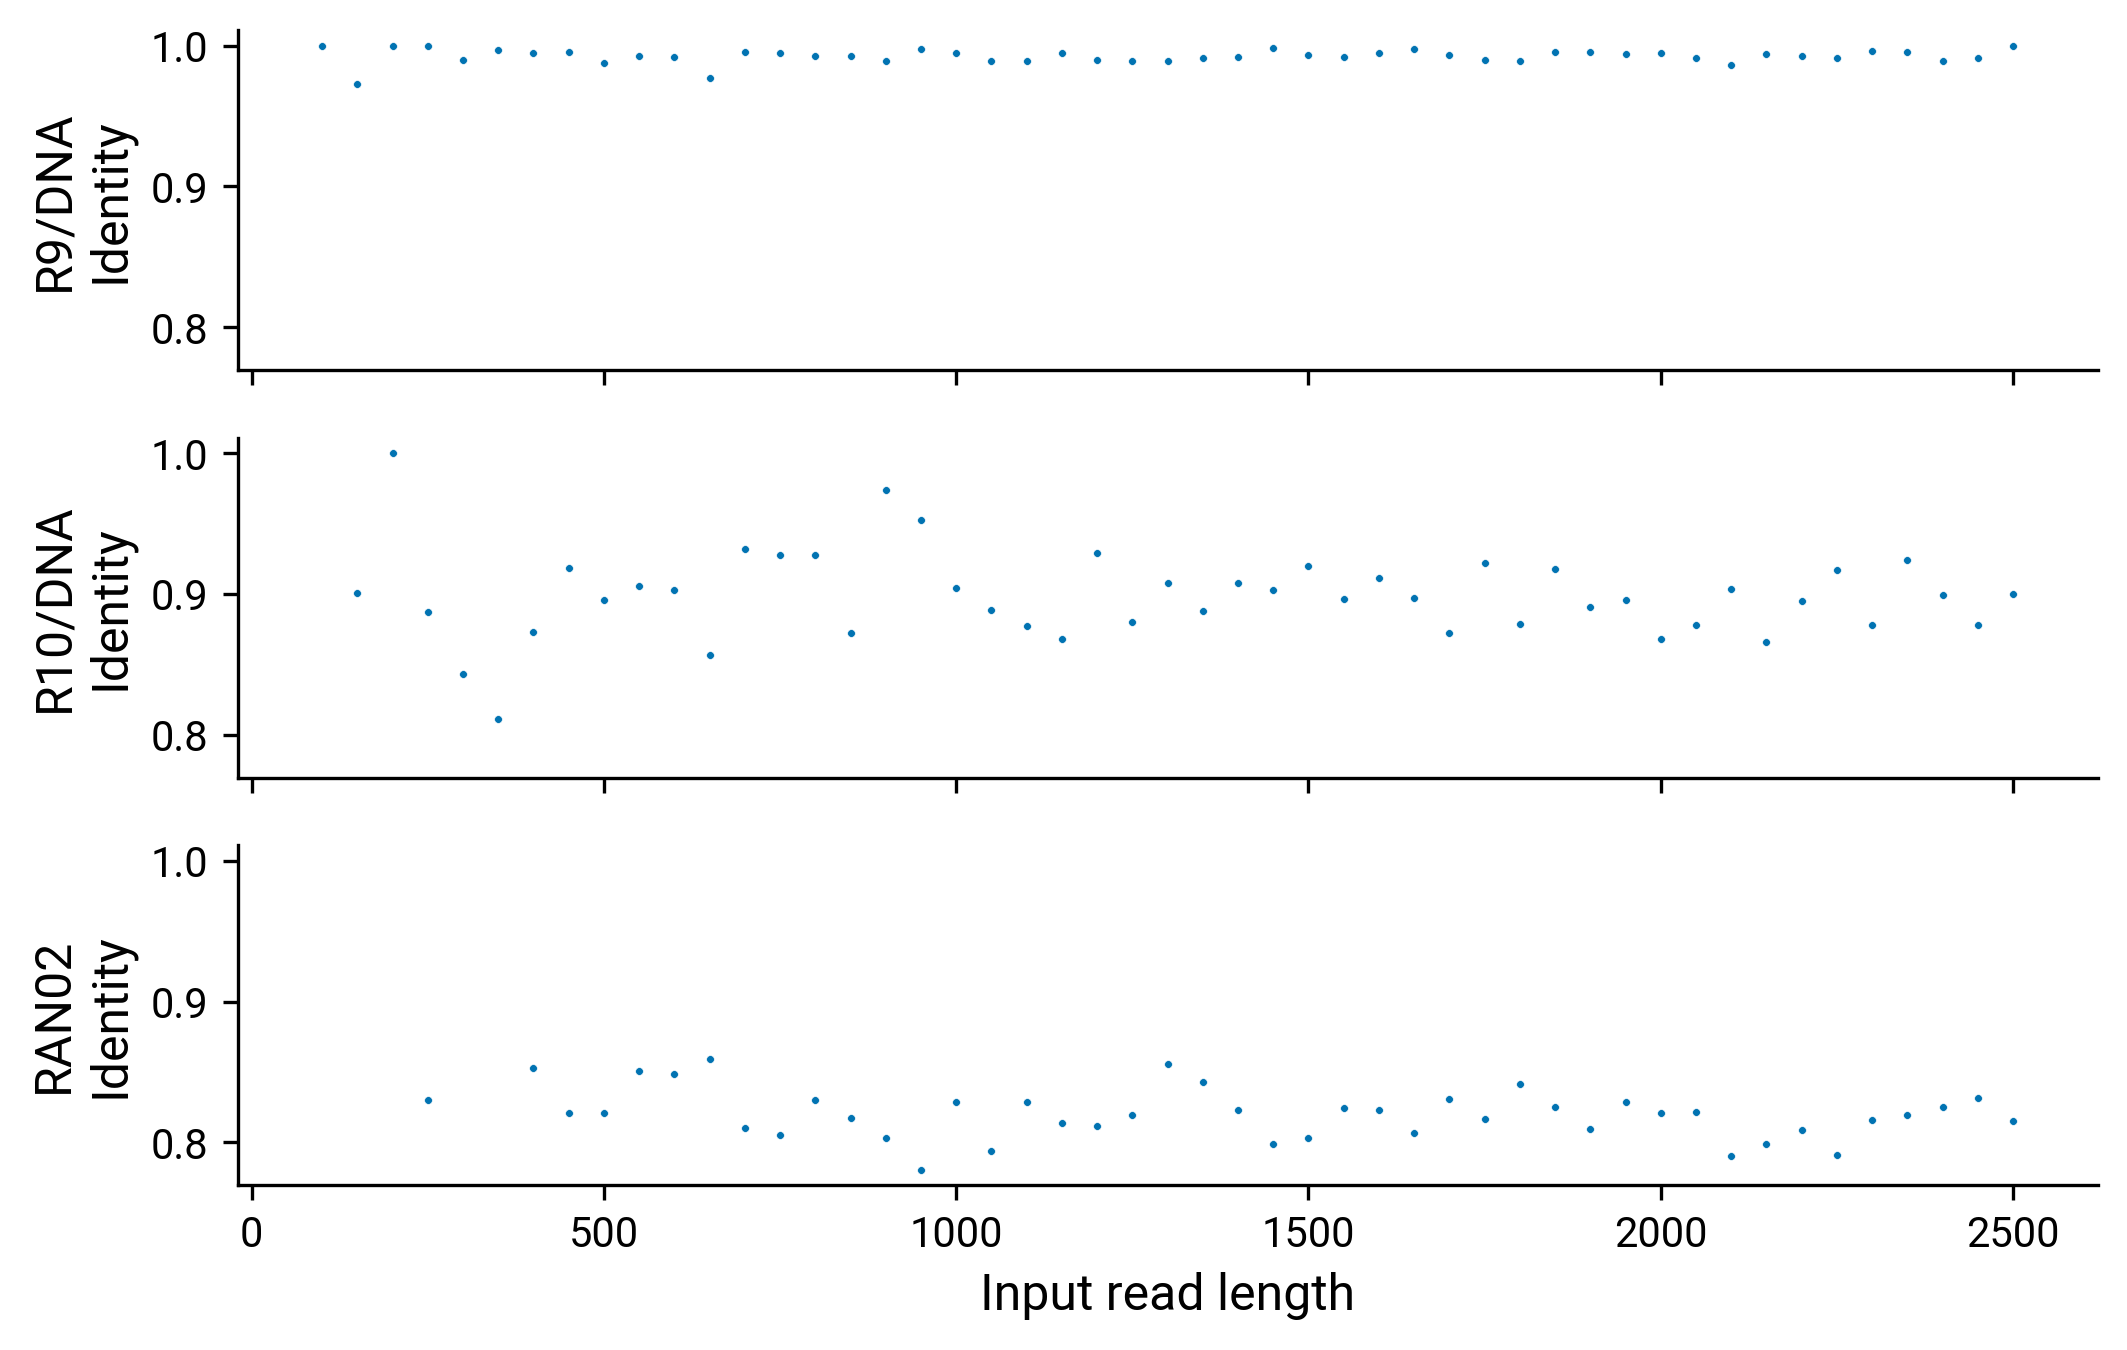

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8,5), sharex=True, sharey=True)
ax = sns.scatterplot(
    x=list(map(lambda x: x[0], r9_identities)),
    y=list(map(lambda x: x[1], r9_identities)),
    s=3.5,
    ax=ax1,
)
ax.tick_params(labelsize=10)
ax.set(ylabel="")
ax = sns.scatterplot(
    x=list(map(lambda x: x[0], r10_identities)),
    y=list(map(lambda x: x[1], r10_identities)),
    s=3.5,
    ax=ax2,
)
ax.tick_params(labelsize=10)

ax.set(ylabel="")
ax = sns.scatterplot(
    x=list(map(lambda x: x[0], rnar9_identities)),
    y=list(map(lambda x: x[1], rnar9_identities)),
    s=3.5,
    ax=ax3,
)
ax.set(ylabel="")
ax.tick_params(labelsize=10)

# ax1.set_title("Simulated read identities")
ax3.set_xlabel("Input read length", fontsize=12)
ax1.set_ylabel("R9/DNA\nIdentity", fontsize=12)
ax2.set_ylabel("R10/DNA\nIdentity", fontsize=12)
ax3.set_ylabel("RAN02\nIdentity", fontsize=12)
fig.savefig("read_identities.svg", dpi=300, bbox_inches="tight")